/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 0.4839  | valid_accuracy: 0.68448 |  0:00:03s
epoch 1  | loss: 0.37562 | valid_accuracy: 0.71227 |  0:00:05s
epoch 2  | loss: 0.36538 | valid_accuracy: 0.73914 |  0:00:08s
epoch 3  | loss: 0.35646 | valid_accuracy: 0.82865 |  0:00:09s
epoch 4  | loss: 0.35496 | valid_accuracy: 0.83587 |  0:00:10s
epoch 5  | loss: 0.35092 | valid_accuracy: 0.84569 |  0:00:12s
epoch 6  | loss: 0.34901 | valid_accuracy: 0.84339 |  0:00:13s
epoch 7  | loss: 0.34547 | valid_accuracy: 0.84708 |  0:00:15s
epoch 8  | loss: 0.34333 | valid_accuracy: 0.8437  |  0:00:16s
epoch 9  | loss: 0.34136 | valid_accuracy: 0.84769 |  0:00:18s
epoch 10 | loss: 0.34178 | valid_accuracy: 0.84661 |  0:00:20s
epoch 11 | loss: 0.33814 | valid_accuracy: 0.8437  |  0:00:21s
epoch 12 | loss: 0.34102 | valid_accuracy: 0.84431 |  0:00:22s
epoch 13 | loss: 0.33739 | valid_accuracy: 0.84661 |  0:00:24s
epoch 14 | loss: 0.33587 | valid_accuracy: 0.84692 |  0:00:25s
epoch 15 | loss: 0.33642 | valid_accuracy: 0.84308 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.51964 | valid_accuracy: 0.58898 |  0:00:02s
epoch 1  | loss: 0.43484 | valid_accuracy: 0.70029 |  0:00:05s
epoch 2  | loss: 0.41768 | valid_accuracy: 0.72916 |  0:00:07s
epoch 3  | loss: 0.4078  | valid_accuracy: 0.78428 |  0:00:09s
epoch 4  | loss: 0.40169 | valid_accuracy: 0.78167 |  0:00:11s
epoch 5  | loss: 0.39372 | valid_accuracy: 0.77798 |  0:00:13s
epoch 6  | loss: 0.38895 | valid_accuracy: 0.77031 |  0:00:15s
epoch 7  | loss: 0.38268 | valid_accuracy: 0.77982 |  0:00:18s
epoch 8  | loss: 0.38098 | valid_accuracy: 0.79103 |  0:00:20s
epoch 9  | loss: 0.37634 | valid_accuracy: 0.78996 |  0:00:22s
epoch 10 | loss: 0.37483 | valid_accuracy: 0.79303 |  0:00:24s
epoch 11 | loss: 0.3736  | valid_accuracy: 0.78658 |  0:00:26s
epoch 12 | loss: 0.37133 | valid_accuracy: 0.79625 |  0:00:28s
epoch 13 | loss: 0.37114 | valid_accuracy: 0.79272 |  0:00:30s
epoch 14 | loss: 0.36922 | valid_accuracy: 0.79456 |  0:00:33s
epoch 15 | loss: 0.3682  | valid_accuracy: 0.79764 |  0

/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


Metrics for model trained on original data:
Accuracy: 0.8557, Precision: 0.7897, Recall: 0.5459

Metrics for model trained on synthetic data:
Accuracy: 0.8059, Precision: 0.5639, Recall: 0.8552


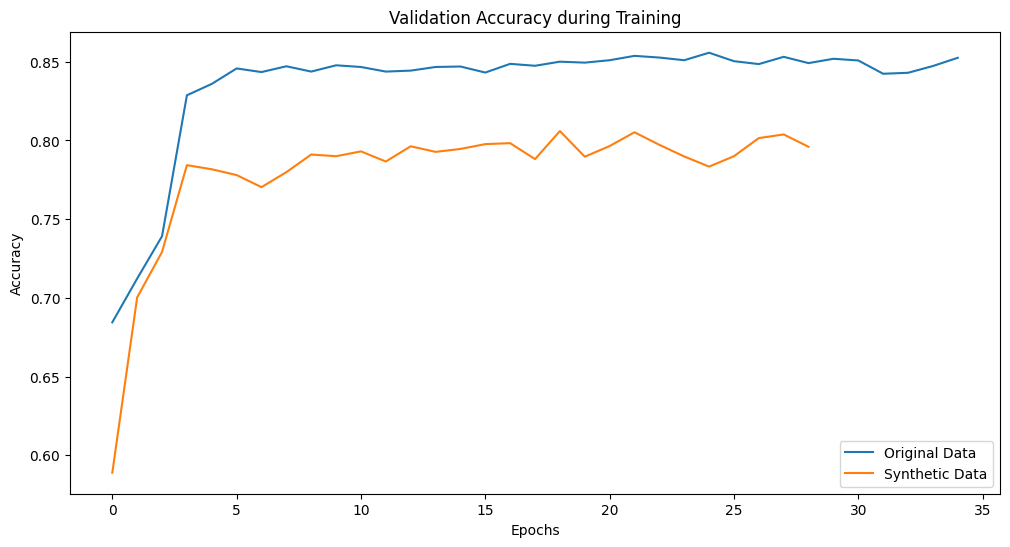

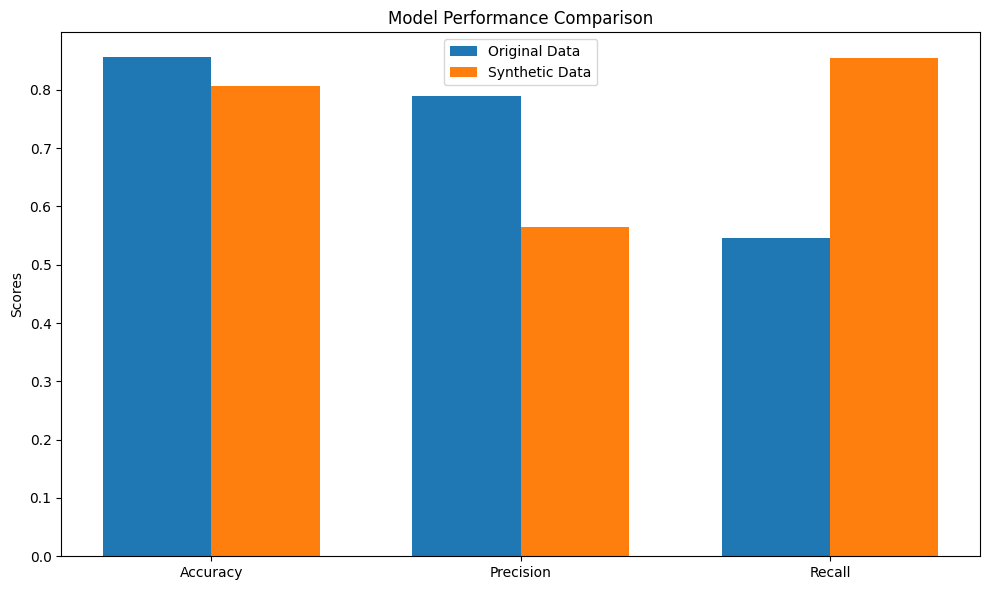

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

# Load Adult Income dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
data = pd.read_csv(url, header=None, names=columns, na_values=' ?', skipinitialspace=True)

# Drop rows with missing values
data.dropna(inplace=True)

# Preprocess categorical and numerical features
categorical_cols = data.select_dtypes(include=['object']).columns[:-1]  # Exclude target
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
target_col = 'income'

# Encode categorical variables
label_encoders = {col: LabelEncoder() for col in categorical_cols}
for col in categorical_cols:
    data[col] = label_encoders[col].fit_transform(data[col])

# Scale numerical variables
scaler = StandardScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

# Encode target variable
data[target_col] = LabelEncoder().fit_transform(data[target_col])

# Split data into train and test sets
X = data.drop(target_col, axis=1).to_numpy()
y = data[target_col].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Generate synthetic data using SMOTE
smote = SMOTE(random_state=42)
X_train_synthetic, y_train_synthetic = smote.fit_resample(X_train, y_train)

# Initialize TabNet model
model_original = TabNetClassifier()
model_synthetic = TabNetClassifier()

# Train model on original data
model_original.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=500,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Train model on synthetic data
model_synthetic.fit(
    X_train_synthetic, y_train_synthetic,
    eval_set=[(X_test, y_test)],
    eval_name=['valid'],
    eval_metric=['accuracy'],
    max_epochs=500,
    patience=10,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)

# Evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    return accuracy, precision, recall

metrics_original = evaluate_model(model_original, X_test, y_test)
metrics_synthetic = evaluate_model(model_synthetic, X_test, y_test)

# Print metrics
print("Metrics for model trained on original data:")
print(f"Accuracy: {metrics_original[0]:.4f}, Precision: {metrics_original[1]:.4f}, Recall: {metrics_original[2]:.4f}")

print("\nMetrics for model trained on synthetic data:")
print(f"Accuracy: {metrics_synthetic[0]:.4f}, Precision: {metrics_synthetic[1]:.4f}, Recall: {metrics_synthetic[2]:.4f}")

# Visualizations
# Training curves
plt.figure(figsize=(12, 6))
plt.plot(model_original.history["valid_accuracy"], label="Original Data")
plt.plot(model_synthetic.history["valid_accuracy"], label="Synthetic Data")
plt.title("Validation Accuracy during Training")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Model comparison bar chart
metrics = ['Accuracy', 'Precision', 'Recall']
original_values = list(metrics_original)
synthetic_values = list(metrics_synthetic)

x = np.arange(len(metrics))  # Label locations
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, original_values, width, label='Original Data')
rects2 = ax.bar(x + width/2, synthetic_values, width, label='Synthetic Data')

ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()
plt.show()


In [9]:
!pip install pytorch_tabnet

In [10]:
# View a sample of the synthetic data
synthetic_data_sample = pd.DataFrame(X_train_synthetic, columns=data.drop(target_col, axis=1).columns)
synthetic_data_sample['income'] = y_train_synthetic
print("Synthetic Data Sample:")
print(synthetic_data_sample.head())


Synthetic Data Sample:
        age  workclass    fnlwgt  education  education-num  marital-status  \
0 -0.482518        4.0 -1.445483        9.0       1.134739             2.0   
1  0.323921        4.0 -0.832115       12.0       1.523438             4.0   
2 -1.362269        0.0 -0.639843       11.0      -0.420060             4.0   
3  0.103983        2.0 -1.563410       15.0      -0.031360             0.0   
4 -1.069018        4.0 -0.718556        9.0       1.134739             4.0   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0         4.0           0.0   4.0  1.0     -0.145920      -0.21666   
1         4.0           1.0   4.0  0.0     -0.145920      -0.21666   
2         0.0           1.0   4.0  0.0     -0.145920      -0.21666   
3        14.0           4.0   4.0  1.0      0.781478      -0.21666   
4        10.0           3.0   4.0  1.0     -0.145920      -0.21666   

   hours-per-week  native-country  income  
0        0.369519            39.0       1  